In [1]:
print("Jai Shree Ganesha")

Jai Shree Ganesha


In [3]:
import os,urllib.request
import torch,tiktoken,tqdm,json
import torch.nn as nn
import numpy as np
import tensorflow as tf 
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader 
from dataclasses import dataclass

In [4]:
@dataclass
class Config:
    n_blocks=1024
    d_emb=768
    n_layers=12
    vocab_size=50257
    n_heads=12
    is_debug=False
    add_bias=True
    head_d_emb=d_emb//n_heads

In [5]:
class LayerNorm(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(config.d_emb))
        self.shift=nn.Parameter(torch.zeros(config.d_emb))

    def forward(self,x):
        mean_value=x.mean(dim=-1,keepdim=True)
        std_value=x.std(dim=-1,keepdim=True)
        normalised_x=x-mean_value/(std_value+self.eps)
        return self.scale*normalised_x+self.shift

In [8]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        )) 

In [10]:
class FeedForwardNN(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(in_features=config.d_emb,out_features=4*config.d_emb),
            GELU(),
            nn.Linear(in_features=4*config.d_emb,out_features=config.d_emb)
        )

    def forward(self,x):
        return self.layers(x)

In [9]:
class CausalMultiHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.w_query=nn.Linear(config.d_emb,config.d_emb,bias=config.add_bias)
        self.w_key=nn.Linear(config.d_emb,config.d_emb,bias=config.add_bias)
        self.w_value=nn.Linear(config.d_emb,config.d_emb,bias=config.add_bias)
        self.final_proj=nn.Linear(config.d_emb,config.d_emb,bias=config.add_bias)
        self.register_buffer('mask',torch.triu(torch.ones(config.n_blocks,config.n_blocks),diagonal=1))

    def forward(self,x):
        batch,tokens,_=x.shape
        query=self.w_query(x)
        key=self.w_key(x)
        value=self.w_value(x)

        query=query.view(batch,tokens,self.config.n_heads,self.config.head_d_emb)
        key=key.view(batch,tokens,self.config.n_heads,self.config.head_d_emb)
        value=value.view(batch,tokens,self.config.n_heads,self.config.head_d_emb)
        
        if self.config.is_debug:
            print(f"Shape of Query:{query.shape}, Shape of Key:{key.shape}, Shape of Value:{value.shape}")
            

        query=query.transpose(1,2)
        key=key.transpose(1,2)
        value=value.transpose(1,2)

        if self.config.is_debug:
            print(f"Shape of Query After Transposing so as to make it compatible to compute attention per head for each token :{query.shape}, Shape of Key:{key.shape}, Shape of Value:{value.shape}")

        scores=query@key.transpose(2,3)
        masking_vector=self.mask.bool()[:tokens,:tokens]
        masked_scores=scores.masked_fill(masking_vector,-torch.inf)

        if self.config.is_debug:
            print(f"Shape of masked scores: {masked_scores.shape}")

        attention_weights=torch.softmax(masked_scores/(key.shape[-1])**0.5,dim=-1)
        if self.config.is_debug:
            print(f"Shape of attention weights: {attention_weights.shape} and Masked Vector is: {attention_weights}")

        context_vector=attention_weights@value 

        context_vector=context_vector.transpose(1,2)

        context_vector=context_vector.contiguous().view(batch,tokens,self.config.d_emb)

        context_vector=self.final_proj(context_vector)

        if self.config.is_debug:
            print(f"Shape of Context rich Vector: {context_vector.shape} and Context Vector is {context_vector}")

        return context_vector

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.attn=CausalMultiHeadAttention(config)
        self.layernorm1=LayerNorm(config)
        self.layernorm2=LayerNorm(config)
        self.ffn=FeedForwardNN(config)

    def forward(self,x):
        shortcut1=x
        x=self.layernorm1(x)
        x=self.attn(x)
        x=x+shortcut1 

        shortcut2=x
        x=self.layernorm2(x)
        x=self.ffn(x)
        x=x+shortcut2

        return x 

In [12]:
class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.token_embedding=nn.Embedding(num_embeddings=config.vocab_size,embedding_dim=config.d_emb)
        self.positional_embedding=nn.Embedding(num_embeddings=config.n_blocks,embedding_dim=config.d_emb)
        self.transformer_blocks=nn.Sequential(
         *[TransformerBlock(config) for _ in range(config.n_layers)]
        )
        self.final_layernorm=LayerNorm(config)
        self.final_projection=nn.Linear(in_features=config.d_emb,out_features=config.vocab_size,bias=False)

    def forward(self,x):
        _,tokens=x.shape
        token_embeddings=self.token_embedding(x)
        pos_embeddings=self.positional_embedding(torch.arange(0,tokens,device=x.device))
        x=token_embeddings+pos_embeddings 

        x=self.transformer_blocks(x)
        x=self.final_layernorm(x)
        x=self.final_projection(x)

        return x 

In [71]:
class FileDownloadFromURL:
    def __init__(self,file_path,url):
        self.file_path=file_path 
        self.url=url 

    def load(self):
        if not os.path.exists(self.file_path):
            with urllib.request.urlopen(self.url) as response:
                text_data = response.read().decode('utf-8')
            with open(self.file_path, "w", encoding="utf-8") as file:
                file.write(text_data)
        else:
            print("File Already Exists")
            with open(self.file_path, "r", encoding="utf-8") as file:
                text_data = file.read()

In [72]:
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
obj=FileDownloadFromURL(file_path,url)
obj.load()

File Already Exists


In [73]:
class DatasetVersion1(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        super().__init__()
        self.input_ids,self.target_ids=[],[]

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        print(f"Total Number of Tokens are: {len(token_ids)}")

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index],self.target_ids[index]

In [74]:
class createDataloader:
    def __init__(self,batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
        self.batch_size=batch_size
        self.max_length=max_length
        self.stride=stride 
        self.shuffle=shuffle 
        self.drop_last=drop_last
        self.num_workers=num_workers 

    def loader(self,txt):
        tokenizer = tiktoken.get_encoding("gpt2")
        dataset = DatasetVersion1(txt, tokenizer, self.max_length, self.stride)

        dataloader=DataLoader(
        dataset, batch_size=self.batch_size, shuffle=self.shuffle, drop_last=self.drop_last, num_workers=self.num_workers)

        return dataloader

In [75]:
with open("/kaggle/working/the-verdict.txt","r") as f:
    text_data=f.read()

total_characters = len(text_data)
tokenizer=tiktoken.get_encoding("gpt2")
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

obj=createDataloader(batch_size=2,max_length=256,stride=256,shuffle=True,drop_last=True,num_workers=0)

train_loader=obj.loader(train_data)
val_loader=obj.loader(val_data)

print("Train loader:")
print(f"Number of Batches in Training Set: {len(train_loader)} and Number of Batches in Validation Set: {len(val_loader)} ")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)


train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


Characters: 20479
Tokens: 5145
Total Number of Tokens are: 4612
Total Number of Tokens are: 534
Train loader:
Number of Batches in Training Set: 9 and Number of Batches in Validation Set: 1 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [83]:
class responseGenerator:
    def __init__(self,is_debug=False):
        self.is_debug=is_debug 

    def generate_text_simple(self, model, idx, max_new_tokens, context_size):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_size:]
            
            if self.is_debug:
                print(f"Current Token Sequence getting used for the prediction is: {idx}")
            
            with torch.no_grad():
                logits = model(idx_cond)

            logits = logits[:, -1, :]

            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  

            idx = torch.cat((idx, idx_next), dim=1)  

        return idx


    def generate_text_advanced(self, model, idx, max_new_tokens, context_size,temperature=0.0,top_k=None,eos_id=None):   
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_size:]
            
            if self.is_debug:
                print(f"Current Token Sequence getting used for the prediction is: {idx}")
            
            with torch.no_grad():
                logits = model(idx_cond)

            logits = logits[:, -1, :]

            if top_k is not None:
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

            if temperature>0.0:
                logits=logits/temperature
                probs=torch.softmax(logits,dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)

            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            if idx_next==eos_id:
                break

            idx = torch.cat((idx, idx_next), dim=1)  

        return idx
        
        
    def text_to_token_ids(self,text, tokenizer):
        encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        encoded_tensor = torch.tensor(encoded).unsqueeze(0)
        if self.is_debug:
            print(f"Encoded tensor is: {encoded_tensor}")
        return encoded_tensor

    def token_ids_to_text(self,token_ids, tokenizer):
        flat = token_ids.squeeze(0) 
        if self.is_debug:
            print(f"Flattened Tokens are: {flat}")
        return tokenizer.decode(flat.tolist())

In [84]:
class LossComputer:
    def __init__(self):
        pass 

    def calc_loss_batch(self,input_batch, target_batch, model, device):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        logits = model(input_batch)
        loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        return loss

    def calc_loss_loader(self,data_loader, model, device, num_batches=None):
        total_loss = 0
        if len(data_loader) == 0:
            return float("nan")
        elif num_batches is None:
            num_batches = len(data_loader)
        else:
            num_batches = min(num_batches, len(data_loader))

        print(f"Number of Batches of Data Participating in Loss Computation: {num_batches}")
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = self.calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
        return total_loss / num_batches

In [85]:
class Trainer:
    def __init__(self):
        self.loss_computer=LossComputer()
        self.response_obj=responseGenerator()

    def train_model_simple(self,model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, start_context, tokenizer):
        
        train_losses, val_losses, track_tokens_seen = [], [], []
        tokens_seen, global_step = 0, -1

        # Let's evaluate losses before any updation 
        
        train_loss, val_loss = self.evaluate_model(
                        model, train_loader, val_loader, device)
        print(f"(Step {global_step:03d}): "
            f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        

        for epoch in range(num_epochs):
            model.train()  
            
            for input_batch, target_batch in train_loader:
                optimizer.zero_grad() 
                loss =  self.loss_computer.calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward() 
                optimizer.step() 
                tokens_seen += input_batch.numel()
                global_step += 1

                if global_step % eval_freq == 0:
                    train_loss, val_loss = self.evaluate_model(
                        model, train_loader, val_loader, device)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"Ep {epoch+1} (Step {global_step:03d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
            
            print(f"Epoch {epoch+1} Ended , Now Going to generate sample text")
            self.generate_and_print_sample(
                model, tokenizer, device, start_context
            )

        return train_losses, val_losses, track_tokens_seen
    
    def evaluate_model(self,model, train_loader, val_loader, device):
        model.eval()
        with torch.no_grad():
            train_loss = self.loss_computer.calc_loss_loader(train_loader, model, device)
            val_loss = self.loss_computer.calc_loss_loader(val_loader, model, device)
        model.train()
        return train_loss, val_loss


    def generate_and_print_sample(self, model, tokenizer, device, start_context):
        model.eval()
        context_size = Config().n_blocks
        encoded = self.response_obj.text_to_token_ids(start_context, tokenizer).to(device)
        with torch.no_grad():
            token_ids = self.response_obj.generate_text_simple(
                model=model, idx=encoded,
                max_new_tokens=30, context_size=context_size
            )
        decoded_text = self.response_obj.token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  
        model.train()

In [86]:
class createOptimizer:
    def create_optimiser(self,model):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
        return optimizer 

In [88]:
with open("/kaggle/working/the-verdict.txt","r") as f:
        text_data=f.read()

device="cuda" if torch.cuda.is_available() else "cpu"
tokenizer=tiktoken.get_encoding("gpt2")
model=GPT(Config())
optimizer=createOptimizer().create_optimiser(model)
num_epochs=10

torch.manual_seed(123) 

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

obj=createDataloader(batch_size=2,max_length=256,stride=256,shuffle=True,drop_last=True,num_workers=0)

train_loader=obj.loader(train_data)
val_loader=obj.loader(val_data)

model.to(device)

trainer=Trainer()
train_losses, val_losses, track_tokens_seen= trainer.train_model_simple(
                                 model=model,
                                 train_loader=train_loader,
                                 val_loader=val_loader,
                                 optimizer=optimizer,
                                 device=device,
                                 num_epochs=num_epochs,
                                 eval_freq=5,
                                 start_context="Hi, This side Abhishek",
                                 tokenizer=tokenizer
                                 )

Total Number of Tokens are: 4612
Total Number of Tokens are: 534
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
(Step -01): Train loss 11.556, Val loss 11.595
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 1 (Step 000): Train loss 44.402, Val loss 43.363
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 1 (Step 005): Train loss 10.193, Val loss 11.279
Epoch 1 Ended , Now Going to generate sample text
Hi, This side Abhishek that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 2 (Step 010): Train loss 12.828, Val loss 15.111
Numbe

- We can see that we are overfitting cause we have very limited data here so we will do something to generate a bit more good text. Let's do some temperature scaling and allow the model to be bit creative. We will do temperature scaling like we try to bring in values closer like decreasing the difference between max and min probas thus increasing the likelihood of index getting selected ...


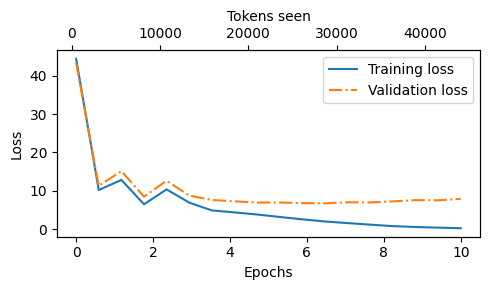

In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  

    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

### Training with Temperature Scaling and TopK

In [91]:
class Trainer:
    def __init__(self):
        self.loss_computer=LossComputer()
        self.response_obj=responseGenerator()

    def train_model_simple(self,model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, start_context, tokenizer):
        
        train_losses, val_losses, track_tokens_seen = [], [], []
        tokens_seen, global_step = 0, -1

        # Let's evaluate losses before any updation 
        
        train_loss, val_loss = self.evaluate_model(
                        model, train_loader, val_loader, device)
        print(f"(Step {global_step:03d}): "
            f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        

        for epoch in range(num_epochs):
            model.train()  
            
            for input_batch, target_batch in train_loader:
                optimizer.zero_grad() 
                loss =  self.loss_computer.calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward() 
                optimizer.step() 
                tokens_seen += input_batch.numel()
                global_step += 1

                if global_step % eval_freq == 0:
                    train_loss, val_loss = self.evaluate_model(
                        model, train_loader, val_loader, device)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"Ep {epoch+1} (Step {global_step:03d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
            
            print(f"Epoch {epoch+1} Ended , Now Going to generate sample text")
            self.generate_and_print_sample(
                model, tokenizer, device, start_context
            )

        return train_losses, val_losses, track_tokens_seen
    
    def evaluate_model(self,model, train_loader, val_loader, device):
        model.eval()
        with torch.no_grad():
            train_loss = self.loss_computer.calc_loss_loader(train_loader, model, device)
            val_loss = self.loss_computer.calc_loss_loader(val_loader, model, device)
        model.train()
        return train_loss, val_loss


    def generate_and_print_sample(self, model, tokenizer, device, start_context):
        model.eval()
        context_size = Config().n_blocks
        encoded = self.response_obj.text_to_token_ids(start_context, tokenizer).to(device)
        with torch.no_grad():
            token_ids = self.response_obj.generate_text_advanced(
                model=model, idx=encoded,
                max_new_tokens=30, context_size=context_size
            )
        decoded_text = self.response_obj.token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  
        model.train()

In [92]:
class createOptimizer:
    def create_optimiser(self,model):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
        return optimizer 

In [94]:
with open("/kaggle/working/the-verdict.txt","r") as f:
        text_data=f.read()

device="cuda" if torch.cuda.is_available() else "cpu"
tokenizer=tiktoken.get_encoding("gpt2")
model=GPT(Config())
optimizer=createOptimizer().create_optimiser(model)
num_epochs=10

torch.manual_seed(123) 

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

obj=createDataloader(batch_size=2,max_length=256,stride=256,shuffle=True,drop_last=True,num_workers=0)

train_loader=obj.loader(train_data)
val_loader=obj.loader(val_data)

model.to(device)

trainer=Trainer()
train_losses, val_losses, track_tokens_seen= trainer.train_model_simple(
                                 model=model,
                                 train_loader=train_loader,
                                 val_loader=val_loader,
                                 optimizer=optimizer,
                                 device=device,
                                 num_epochs=num_epochs,
                                 eval_freq=5,
                                 start_context="Hi, This side Abhishek",
                                 tokenizer=tokenizer
                                 )

Total Number of Tokens are: 4612
Total Number of Tokens are: 534
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
(Step -01): Train loss 11.556, Val loss 11.595
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 1 (Step 000): Train loss 44.402, Val loss 43.363
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 1 (Step 005): Train loss 10.193, Val loss 11.279
Epoch 1 Ended , Now Going to generate sample text
Hi, This side Abhishek that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that
Number of Batches of Data Participating in Loss Computation: 9
Number of Batches of Data Participating in Loss Computation: 1
Ep 2 (Step 010): Train loss 12.828, Val loss 15.111
Numbe

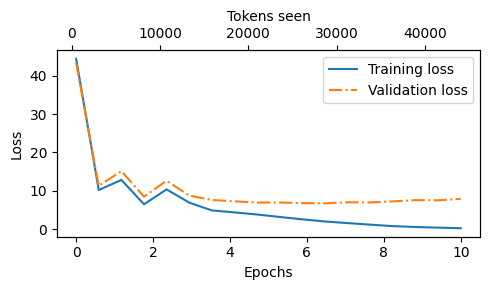

In [97]:
num_epochs=10
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  

    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

In [73]:
# torch.save(model.state_dict(), "model.pth")

In [74]:
# model = GPT(Config())
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
# model.eval();

In [35]:
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     }, 
#     "model_and_optimizer.pth"
# )

In [98]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPT(Config())
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
Trainer().generate_and_print_sample(model,tokenizer,device,start_context="Hi, This side Abhishek")

Hi, This side Abhishek--oh to some was _was, he was one in the house."  " went on everlasting had been him, and he had the window


- Loading Weights From GPT [Released By OpenAI]

In [99]:
def download_file(url, destination):
    with urllib.request.urlopen(url) as response:
        file_size = int(response.headers.get("Content-Length", 0))
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        block_size = 1024  
        progress_bar_description = os.path.basename(url)  
        with tqdm.tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            with open(destination, "wb") as file:
                while True:
                    chunk = response.read(block_size)
                    if not chunk:
                        break
                    file.write(chunk)
                    progress_bar.update(len(chunk))  

In [100]:
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}
    for name, _ in tf.train.list_variables(ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))
        variable_name_parts = name.split("/")[1:]  
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [101]:
def download_and_load_gpt2(model_size, models_dir):
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

In [102]:
settings, params =download_and_load_gpt2("124M","pre-trainedweights")

File already exists and is up-to-date: pre-trainedweights/124M/checkpoint
File already exists and is up-to-date: pre-trainedweights/124M/encoder.json
File already exists and is up-to-date: pre-trainedweights/124M/hparams.json
File already exists and is up-to-date: pre-trainedweights/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: pre-trainedweights/124M/model.ckpt.index
File already exists and is up-to-date: pre-trainedweights/124M/model.ckpt.meta
File already exists and is up-to-date: pre-trainedweights/124M/vocab.bpe


In [103]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [104]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [105]:
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Token embedding weight tensor dimensions: (50257, 768)


In [106]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [108]:
model=GPT(Config())
model.eval();

In [109]:
#Without Loading Weights
model.to(device);
print(model.token_embedding.weight==torch.tensor(params['wte']).to(device))

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


In [110]:
def load_weights_into_model(model, params):
    model.positional_embedding.weight = assign(model.positional_embedding.weight, params['wpe'])
    model.token_embedding.weight = assign(model.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        model.transformer_blocks[b].attn.w_query.weight = assign(
            model.transformer_blocks[b].attn.w_query.weight, q_w.T)
        model.transformer_blocks[b].attn.w_key.weight = assign(
            model.transformer_blocks[b].attn.w_key.weight, k_w.T)
        model.transformer_blocks[b].attn.w_value.weight = assign(
            model.transformer_blocks[b].attn.w_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        model.transformer_blocks[b].attn.w_query.bias = assign(
            model.transformer_blocks[b].attn.w_query.bias, q_b)
        model.transformer_blocks[b].attn.w_key.bias = assign(
            model.transformer_blocks[b].attn.w_key.bias, k_b)
        model.transformer_blocks[b].attn.w_value.bias = assign(
            model.transformer_blocks[b].attn.w_value.bias, v_b)

        model.transformer_blocks[b].attn.final_proj.weight = assign(
            model.transformer_blocks[b].attn.final_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        model.transformer_blocks[b].attn.final_proj.bias = assign(
            model.transformer_blocks[b].attn.final_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        model.transformer_blocks[b].ffn.layers[0].weight = assign(
            model.transformer_blocks[b].ffn.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        model.transformer_blocks[b].ffn.layers[0].bias = assign(
            model.transformer_blocks[b].ffn.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        model.transformer_blocks[b].ffn.layers[2].weight = assign(
            model.transformer_blocks[b].ffn.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        model.transformer_blocks[b].ffn.layers[2].bias = assign(
            model.transformer_blocks[b].ffn.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        model.transformer_blocks[b].layernorm1.scale = assign(
            model.transformer_blocks[b].layernorm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        model.transformer_blocks[b].layernorm1.shift = assign(
            model.transformer_blocks[b].layernorm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        model.transformer_blocks[b].layernorm2.scale = assign(
            model.transformer_blocks[b].layernorm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        model.transformer_blocks[b].layernorm2.shift = assign(
            model.transformer_blocks[b].layernorm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    model.final_layernorm.scale = assign(model.final_layernorm.scale, params["g"])
    model.final_layernorm.shift = assign(model.final_layernorm.shift, params["b"])
    model.final_projection.weight = assign(model.final_projection.weight, params["wte"])
    
    
load_weights_into_model(model, params)
model.to(device);

In [111]:
# After Loading Weights 
model.to(device);
print(model.token_embedding.weight==torch.tensor(params['wte']).to(device))

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')


In [114]:
torch.manual_seed(123)

response_obj=responseGenerator()
token_ids = response_obj.generate_text_advanced(
    model=model,
    idx=response_obj.text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=1024,
    top_k=50,
    temperature=1.4
)
print("Output text:\n", response_obj.token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you crossed extended crossed crossed crossed crossed crossed crossed crossed crossed crossed crossed crossed crossed crossed
